# Saving Models and Hisotry

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

for root, dirs, files in os.walk('/content/drive/MyDrive/Rock_Paper_Scissors_Models'):
    print(f"\n📁 {root}")
    for file in files:
        print(f"  - {file}")


📁 /content/drive/MyDrive/Rock_Paper_Scissors_Models

📁 /content/drive/MyDrive/Rock_Paper_Scissors_Models/mlp

📁 /content/drive/MyDrive/Rock_Paper_Scissors_Models/mlp/sgd
  - model.keras
  - history.json

📁 /content/drive/MyDrive/Rock_Paper_Scissors_Models/mlp/sgd_momentum
  - model.keras
  - history.json

📁 /content/drive/MyDrive/Rock_Paper_Scissors_Models/mlp/adagrad
  - model.keras
  - history.json

📁 /content/drive/MyDrive/Rock_Paper_Scissors_Models/mlp/rmsprop
  - model.keras
  - history.json

📁 /content/drive/MyDrive/Rock_Paper_Scissors_Models/mlp/adam
  - model.keras
  - history.json

📁 /content/drive/MyDrive/Rock_Paper_Scissors_Models/cnn

📁 /content/drive/MyDrive/Rock_Paper_Scissors_Models/cnn/SGD_new
  - model.keras
  - history.json

📁 /content/drive/MyDrive/Rock_Paper_Scissors_Models/cnn/SGD_momentum_new
  - model.keras
  - history.json

📁 /content/drive/MyDrive/Rock_Paper_Scissors_Models/cnn/Adagrad_new
  - model.keras
  - history.json

📁 /content/drive/MyDrive/Rock_Paper_S

In [ ]:
import os
import json
base_path = '/content/drive/MyDrive/Rock_Paper_Scissors_Models'

# Create structure
os.makedirs(f'{base_path}/mlp', exist_ok=True)
os.makedirs(f'{base_path}/cnn', exist_ok=True)

In [ ]:
def save_model_and_history(model, history, base_dir, model_type, optimizer_name):
    path = os.path.join(base_dir, model_type, optimizer_name)
    os.makedirs(path, exist_ok=True)

    # Save model
    model.save(os.path.join(path, "model.keras"))

    # Save history
    with open(os.path.join(path, "history.json"), "w") as f:
        json.dump(history.history, f)

    print(f"✅ Saved model to {path}/model.keras")
    print(f"✅ Saved history to {path}/history.json")

# Dataset Preparation

Pipeline :

1 - Load dataset from tensorflow

2 - Get Class Labels

3 - Create a preprocessing function

4 - Resize image

5 - Apply binary transformation /255

6 - Split Data into 90% training and 10% validation (this dataset has a predefined testing set)

7 - Apply preproccessing

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets , layers , models , losses , optimizers , metrics
from tensorflow.keras.models import load_model

In [ ]:
# Load
(ds_train_full, ds_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

# Label classes (index to name)
label_names = ds_info.features['label'].names
print("Class labels:", label_names)


Class labels: ['rock', 'paper', 'scissors']


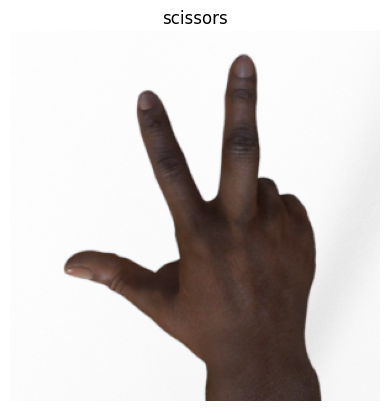

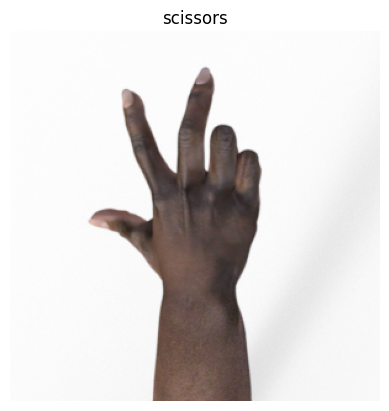

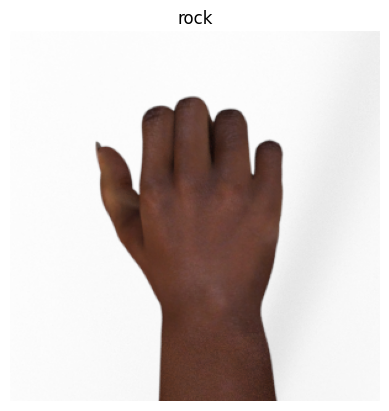

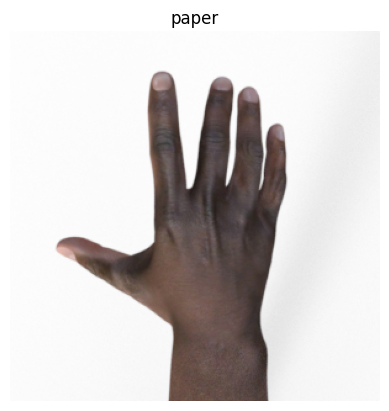

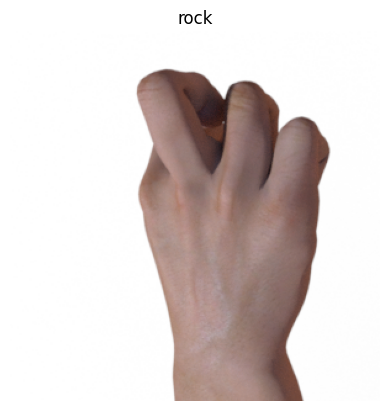

In [ ]:
def preprocess(image, label):
    image = tf.image.resize(image, [300, 300])
    image = tf.cast(image, tf.float32) / 255.0  # normalize
    return image, label

for image, label in ds_train_full.take(5):
    plt.imshow(image)
    plt.title(label_names[label.numpy()])
    plt.axis('off')
    plt.show()

In [ ]:
train_size = int(0.9 * tf.data.experimental.cardinality(ds_train_full).numpy())
ds_train = ds_train_full.take(train_size)
ds_val = ds_train_full.skip(train_size)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.map(preprocess).shuffle(1000).batch(32).prefetch(AUTOTUNE)
ds_val   = ds_val.map(preprocess).batch(32).prefetch(AUTOTUNE)
ds_test  = ds_test.map(preprocess).batch(32).prefetch(AUTOTUNE)

In [ ]:
for images, labels in ds_train.take(1):
    print("Batch image shape:", images.shape)
    print("Pixel range:", tf.reduce_min(images).numpy(), "-", tf.reduce_max(images).numpy())
    print("Label batch:", labels.numpy())

Batch image shape: (32, 300, 300, 3)
Pixel range: 0.015686275 - 1.0
Label batch: [0 0 2 0 1 1 2 2 2 1 1 0 2 1 1 0 0 2 1 0 2 0 2 2 0 0 1 1 0 0 0 2]


The two recent code cells are for batching , The output above is between 0.035 - 1 , not 0-1 as the normalized values of pixels but this is because i am debugging for one batch to make sure data is loaded correctly

In [ ]:
def get_final_metrics(history):
    train_loss = history.history['loss'][-1]
    train_acc = history.history['accuracy'][-1]
    val_loss = history.history['val_loss'][-1]
    val_acc = history.history['val_accuracy'][-1]

    return {
        'Train Loss': round(train_loss, 4),
        'Train Acc': round(train_acc, 4),
        'Val Loss': round(val_loss, 4),
        'Val Acc': round(val_acc, 4)
    }


In [ ]:
def plot_history(history, optimizer_name):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Val Loss')
    plt.title(f'{optimizer_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Train Acc')
    plt.plot(epochs, history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{optimizer_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# MLP Exclusive (This is a helper function to convert to Numpy arrays )

def to_numpy(ds):
    images, labels = [], []
    for batch_imgs, batch_labels in tfds.as_numpy(ds):
        images.extend(batch_imgs)
        labels.extend(batch_labels)
    return np.array(images), np.array(labels)

x_train, y_train = to_numpy(ds_train)
x_val, y_val     = to_numpy(ds_val)
x_test, y_test   = to_numpy(ds_test)

----------------------------------------------

# MLP

**Topology/Strucutre**

Input layer : Flatten image

Hidden Layer 1 : capture low level features (edges , brightness , etc.)

Hidden Layer 2 : capture high level featues (outer view)

Output Layer : Classification

In [ ]:
#Model function

def MLP(optimizer):
    model = models.Sequential([
        layers.Flatten(input_shape=(300, 300, 3)),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    model.summary()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

--------------------------------------------------------------------------------------------

**SGD (Stochastic_Gradient_Descent)**

In [ ]:
sgd_optimizer = optimizers.SGD(learning_rate=0.01)
sgd_model_mlp = MLP(sgd_optimizer)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 270000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   138,240,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,372,611 (527.85 MB)

 Trainable params: 138,372,611 (527.85 MB)

 Non-trainable params: 0 (0.00 B)

params = input * output + bias

flatten_9 = 300 x 300 x 3 = 270000

dense_27 = 270000 * 512 + 512

dense_28 = 512 * 256 + 256 = 131328

dense_29 = 256 * 3 + 3 = 771

I will use a numpy array for MLP and tfds for CNN , this wont create a bias its just that numpy is nto wokring with CNN

In [ ]:
output_sgd_mlp = sgd_model_mlp.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.3332 - loss: 733.9935 - val_accuracy: 0.3333 - val_loss: 1.1016
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.3384 - loss: 1.0999 - val_accuracy: 0.3333 - val_loss: 1.0997
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3396 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0995
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.3628 - loss: 1.0970 - val_accuracy: 0.3333 - val_loss: 1.0994
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3413 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0993
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3438 - loss: 1.0985 - val_accuracy: 0.3333 - val_loss: 1.0993
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.3287 - loss: 1.0988 - val_accuracy: 0.3333 - val_loss: 1.0993
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3331 - loss: 1.0987 - val_accuracy: 0.3333 -

In [ ]:
save_model_and_history(sgd_model_mlp, output_sgd_mlp, base_path, "mlp", "sgd")

✅ Saved model to /content/drive/MyDrive/Rock_Paper_Scissors_Models/mlp/sgd/model.keras
✅ Saved history to /content/drive/MyDrive/Rock_Paper_Scissors_Models/mlp/sgd/history.json


----------------------------------------------

**SGD with Momentum**

In [ ]:
sgd_momentum = optimizers.SGD(learning_rate=0.01, momentum=0.9)
sgd_momentum_model_mlp = MLP(sgd_momentum)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 270000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   138,240,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,372,611 (527.85 MB)

 Trainable params: 138,372,611 (527.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
output_sgd_momentum_mlp = sgd_momentum_model_mlp.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.3280 - loss: 266.2179 - val_accuracy: 0.3333 - val_loss: 1.3866
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.3227 - loss: 1.2802 - val_accuracy: 0.3333 - val_loss: 1.1139
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.3251 - loss: 1.1449 - val_accuracy: 0.3333 - val_loss: 1.1875
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.3442 - loss: 1.1581 - val_accuracy: 0.3333 - val_loss: 1.3411
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3446 - loss: 1.1614 - val_accuracy: 0.3333 - val_loss: 1.2129
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3445 - loss: 1.1832 - val_accuracy: 0.3333 - val_loss: 1.2343
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.3427 - loss: 1.1741 - val_accuracy: 0.3333 - val_loss: 1.1018
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.3271 - loss: 1.1926 - val_accuracy: 0.3333 

In [ ]:
save_model_and_history(sgd_momentum_model_mlp, output_sgd_momentum_mlp, base_path, "mlp", "sgd_momentum")

✅ Saved model to /content/drive/MyDrive/Rock_Paper_Scissors_Models/mlp/sgd_momentum/model.keras
✅ Saved history to /content/drive/MyDrive/Rock_Paper_Scissors_Models/mlp/sgd_momentum/history.json


----------------------------------------------

**AdaGrad**

In [ ]:
adagrad = optimizers.Adagrad(learning_rate=0.01)
adagrad_model_mlp = MLP(adagrad)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 270000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   138,240,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,372,611 (527.85 MB)

 Trainable params: 138,372,611 (527.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
output_adagrad_mlp = adagrad_model_mlp.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.3349 - loss: 89.0374 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.3334 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.3490 - loss: 1.0984 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.3452 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.3483 - loss: 1.0983 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.3296 - loss: 1.0982 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.3429 - loss: 1.0985 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.3367 - loss: 1.0987 - val_accuracy: 0.3333 - 

In [ ]:
save_model_and_history(adagrad_model_mlp, output_adagrad_mlp, base_path, "mlp", "adagrad")

✅ Saved model to /content/drive/MyDrive/Rock_Paper_Scissors_Models/mlp/adagrad/model.keras
✅ Saved history to /content/drive/MyDrive/Rock_Paper_Scissors_Models/mlp/adagrad/history.json


----------------------------------------------

**RMSProp**

In [ ]:
rmsprop = optimizers.RMSprop(learning_rate=0.01)
rmsprop_model_mlp = MLP(rmsprop)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 270000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   138,240,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,372,611 (527.85 MB)

 Trainable params: 138,372,611 (527.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
output_rmsprop_mlp = rmsprop_model_mlp.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.3222 - loss: 8239.0391 - val_accuracy: 0.3333 - val_loss: 1.1015
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.3441 - loss: 1.3339 - val_accuracy: 0.3333 - val_loss: 1.0994
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.3475 - loss: 1.0995 - val_accuracy: 0.3333 - val_loss: 1.0990
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.3411 - loss: 1.0999 - val_accuracy: 0.3333 - val_loss: 1.0998
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.3240 - loss: 1.0990 - val_accuracy: 0.3333 - val_loss: 1.0989
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.3168 - loss: 1.0998 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.3366 - loss: 1.0991 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.3253 - loss: 1.0997 - val_accuracy: 0.3333 

In [ ]:
save_model_and_history(rmsprop_model_mlp, output_rmsprop_mlp, base_path, "mlp", "RMSProp")

✅ Saved model to /content/drive/MyDrive/Rock_Paper_Scissors_Models/mlp/RMSProp/model.keras
✅ Saved history to /content/drive/MyDrive/Rock_Paper_Scissors_Models/mlp/RMSProp/history.json


----------------------------------------------

**Adam**

In [ ]:
adam = optimizers.Adam(learning_rate=0.01)
adam_model_mlp = MLP(adam)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 270000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   138,240,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,372,611 (527.85 MB)

 Trainable params: 138,372,611 (527.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
output_adam_mlp = adam_model_mlp.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.4004 - loss: 1453.1078 - val_accuracy: 0.3333 - val_loss: 1.0989
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.3206 - loss: 6.6685 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.3206 - loss: 1.0989 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.3524 - loss: 1.0984 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 215s 3s/step - accuracy: 0.3441 - loss: 1.0989 - val_accuracy: 0.3333 - val_loss: 1.0988
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.3381 - loss: 1.0989 - val_accuracy: 0.3333 - val_loss: 1.0989
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - accuracy: 0.3353 - loss: 1.0987 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.3464 - loss: 1.0986 - val_accuracy: 0.3333 

In [ ]:
save_model_and_history(adam_model_mlp, output_adam_mlp, base_path, "mlp", "Adam")

✅ Saved model to /content/drive/MyDrive/Rock_Paper_Scissors_Models/mlp/Adam/model.keras
✅ Saved history to /content/drive/MyDrive/Rock_Paper_Scissors_Models/mlp/Adam/history.json


----------------------------------------------

----------------------------------------------

# CNN

**Topology/Strucutre:**

Layer 1 : Convolutional layer 1  32 (Detects low-level features)

Layers 2 : MaxPooling (Reduce Features)

Layer 3 : Convolutional layer 2  64 (Detects high level features)

Layer 4 : Maxpooling (Feature reduction)

Layer 5 : Convolutional layer 3 128 (Actually learns patterns)

Layer 6 : final Maxpooling

Layer 4 : Global Average Pooling (Explanation TBC)

Layer 5 : Fully Connected Layer

Layer 6 : Output Layer (classification)

⚠️ PLEASE MAKE SURE TO READ THIS FOR CLARIFICATION


I used Global Average Pooling after i noticed a huge explosion in the params , while flatten converts all the inputs into a 1D vector , Global Average Pooling summarizes each feature map into just 1 value just like Pooling layer it helps in extracting the most dominant feature to pass to the Classifier , This is more efficient and will help prevent overfitting as the model will be learning generalized patterns and wont adapt to the training set

In [ ]:
def CNN(optimizer):
  model = models.Sequential([

    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300,3)),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),

    layers.Conv2D(64,(3,3) , activation='relu'),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),


    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),

    layers.Flatten(),
    layers.Dense(64 , activation='relu') ,
    layers.Dense(3 , activation='softmax')


  ])


  model.summary()
  model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
  return model




**SGD**

In [ ]:
sgd_optimizer = optimizers.SGD(learning_rate=0.01)
cnn_sgd = CNN(sgd_optimizer)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │    10,035,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,128,707 (38.64 MB)

 Trainable params: 10,128,707 (38.64 MB)

 Non-trainable params: 0 (0.00 B)

params  = ( filter_size x previous input x bias ) x no. of filters

**Each Filter has 1 bias instead of a bias for each weight which contributes in reducing params (Weight Sharing and local connectivity concepts)**

Convolutional Layer 1 :  ( 3 x 3 x 3 + 1 ) x 32 = 896

Pooling Layer 1 : No trainable params (Feature reduction only)

Convolutional Layer 2 :  ( 3 x 3 x 32 + 1 ) x 64 = 18496

Pooling Layer 2 : No trainable params (Feature reduction only)

Convolutional Layer 3 :  ( 3 x 3 x 64 + 1 ) x 128 = 73856

Pooling Layer 3 : No trainable params (Feature reduction only preparing for flattening)


Flatten to a 1D vector

Fully connected Layer : 128 x 64 + 64 = 8256

Output Layer :  64 x 3 + 3 = 195

In [ ]:
output_sgd_cnn = cnn_sgd.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 26s 240ms/step - accuracy: 0.3514 - loss: 1.1039 - val_accuracy: 0.6349 - val_loss: 1.0603
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.4618 - loss: 1.0533 - val_accuracy: 0.5357 - val_loss: 0.9700
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.5430 - loss: 0.9616 - val_accuracy: 0.6667 - val_loss: 0.8026
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.6282 - loss: 0.8350 - val_accuracy: 0.8333 - val_loss: 0.6437
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.7372 - loss: 0.6859 - val_accuracy: 0.8016 - val_loss: 0.6215
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.8180 - loss: 0.5282 - val_accuracy: 0.9048 - val_loss: 0.3013
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9016 - loss: 0.2992 - val_accuracy: 0.9722 - val_loss: 0.1386
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.9746 - loss: 0.1052 - val_accuracy: 0.924

In [ ]:
save_model_and_history(cnn_sgd, output_sgd_cnn, base_path, "cnn", "SGD_new")

✅ Saved model to /content/drive/MyDrive/Rock_Paper_Scissors_Models/cnn/SGD_new/model.keras
✅ Saved history to /content/drive/MyDrive/Rock_Paper_Scissors_Models/cnn/SGD_new/history.json


**SGD with Momentum**

In [ ]:
sgd_momentum = optimizers.SGD(learning_rate=0.01, momentum=0.9)
cnn_sgd_momentum = CNN(sgd_momentum)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │    10,035,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,128,707 (38.64 MB)

 Trainable params: 10,128,707 (38.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
output_sgd_momentum_cnn = cnn_sgd_momentum.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.4494 - loss: 1.0484 - val_accuracy: 0.6508 - val_loss: 0.8328
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.7519 - loss: 0.6164 - val_accuracy: 0.9484 - val_loss: 0.1571
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9827 - loss: 0.0561 - val_accuracy: 0.9881 - val_loss: 0.0325
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.9980 - loss: 0.0090 - val_accuracy: 0.9921 - val_loss: 0.0544
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9979 - loss: 0.0046 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 1.0000 - loss: 7.3877e-04 - val_accuracy: 1.0000 - val_loss: 4.3426e-04
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 1.0000 - loss: 9.5393e-05 - val_accuracy: 1.0000 - val_loss: 3.6810e-04
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 1.0000 - loss: 6.6389e-05 - v

In [ ]:
save_model_and_history(cnn_sgd_momentum, output_sgd_momentum_cnn, base_path, "cnn", "SGD_momentum_new")

✅ Saved model to /content/drive/MyDrive/Rock_Paper_Scissors_Models/cnn/SGD_momentum_new/model.keras
✅ Saved history to /content/drive/MyDrive/Rock_Paper_Scissors_Models/cnn/SGD_momentum_new/history.json


**ADAGRAD**

In [ ]:
adagrad = optimizers.Adagrad(learning_rate=0.01)
cnn_adagrad = CNN(adagrad)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │    10,035,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,128,707 (38.64 MB)

 Trainable params: 10,128,707 (38.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
output_adagrad_cnn = cnn_adagrad.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.4173 - loss: 1.1521 - val_accuracy: 0.5595 - val_loss: 1.0128
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.6893 - loss: 0.8109 - val_accuracy: 0.8730 - val_loss: 0.4384
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9323 - loss: 0.2252 - val_accuracy: 0.9921 - val_loss: 0.0518
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9903 - loss: 0.0468 - val_accuracy: 0.9960 - val_loss: 0.0210
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9975 - loss: 0.0162 - val_accuracy: 1.0000 - val_loss: 0.0097
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9982 - loss: 0.0105 - val_accuracy: 1.0000 - val_loss: 0.0062
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 1.0000 - val_loss: 0.0049
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 1.0000 -

In [ ]:
save_model_and_history(cnn_adagrad, output_adagrad_cnn, base_path, "cnn", "Adagrad_new")

✅ Saved model to /content/drive/MyDrive/Rock_Paper_Scissors_Models/cnn/Adagrad_new/model.keras
✅ Saved history to /content/drive/MyDrive/Rock_Paper_Scissors_Models/cnn/Adagrad_new/history.json


**RMSPROP**

In [ ]:
rmsprop = optimizers.RMSprop(learning_rate=0.0001)
cnn_rmsprop = CNN(rmsprop)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │    10,035,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,128,707 (38.64 MB)

 Trainable params: 10,128,707 (38.64 MB)

 Non-trainable params: 0 (0.00 B)

Unlike adagrad , sgd and sgd with momentum : i will use a lower learning rate with rmsprop , this wont create a bias its just that i suspect gradeint decay

In [ ]:
output_rmsprop_cnn = cnn_rmsprop.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.4419 - loss: 1.8093 - val_accuracy: 0.8254 - val_loss: 0.5727
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.8683 - loss: 0.4562 - val_accuracy: 0.9643 - val_loss: 0.1419
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.9721 - loss: 0.1370 - val_accuracy: 0.9881 - val_loss: 0.0733
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.9915 - loss: 0.0440 - val_accuracy: 0.9960 - val_loss: 0.0168
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9960 - loss: 0.0136 - val_accuracy: 0.9960 - val_loss: 0.0087
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.9978 - loss: 0.0068 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 1.0000 - loss: 5.4608e-04 - val_accuracy: 1.

In [ ]:
save_model_and_history(cnn_rmsprop, output_rmsprop_cnn, base_path, "cnn", "RMSProp_new")

✅ Saved model to /content/drive/MyDrive/Rock_Paper_Scissors_Models/cnn/RMSProp_new/model.keras
✅ Saved history to /content/drive/MyDrive/Rock_Paper_Scissors_Models/cnn/RMSProp_new/history.json


**ADAM**

In [ ]:
adam = optimizers.Adam(learning_rate=0.0001)
cnn_adam = CNN(adam)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │    10,035,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,128,707 (38.64 MB)

 Trainable params: 10,128,707 (38.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
output_adam_cnn = cnn_adam.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - accuracy: 0.5492 - loss: 0.9870 - val_accuracy: 0.9048 - val_loss: 0.3511
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9634 - loss: 0.2174 - val_accuracy: 0.9921 - val_loss: 0.0506
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9869 - loss: 0.0523 - val_accuracy: 1.0000 - val_loss: 0.0161
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9989 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 0.0137
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9989 - loss: 0.0099 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 

In [ ]:
save_model_and_history(cnn_adam, output_adam_cnn, base_path, "cnn", "Adam_new")

✅ Saved model to /content/drive/MyDrive/Rock_Paper_Scissors_Models/cnn/Adam_new/model.keras
✅ Saved history to /content/drive/MyDrive/Rock_Paper_Scissors_Models/cnn/Adam_new/history.json


⚠️ Note: Adam and RMSProp performed poorly at first due to a high learning rate (0.01). These adaptive optimizers are sensitive to large updates because of their internal momentum (gamma value) , i reduced learning rate for both this is not a bias between optmizer its just the sensitivity of both architectures.

# EVALUATION (Training)

**Graphs**

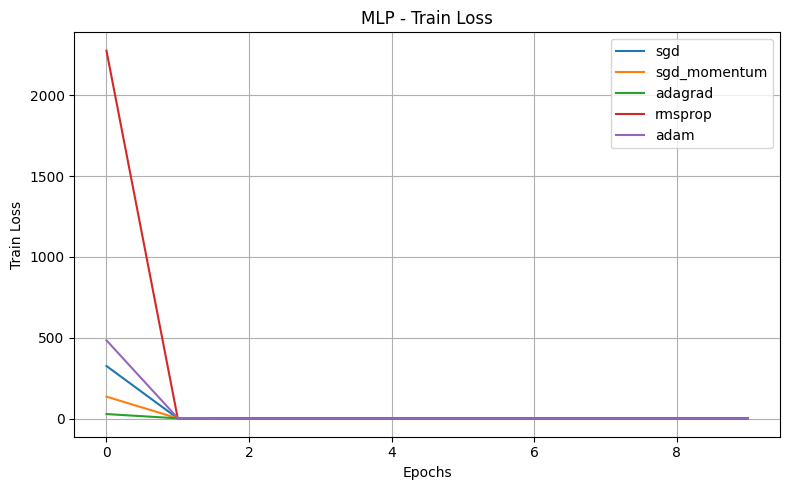

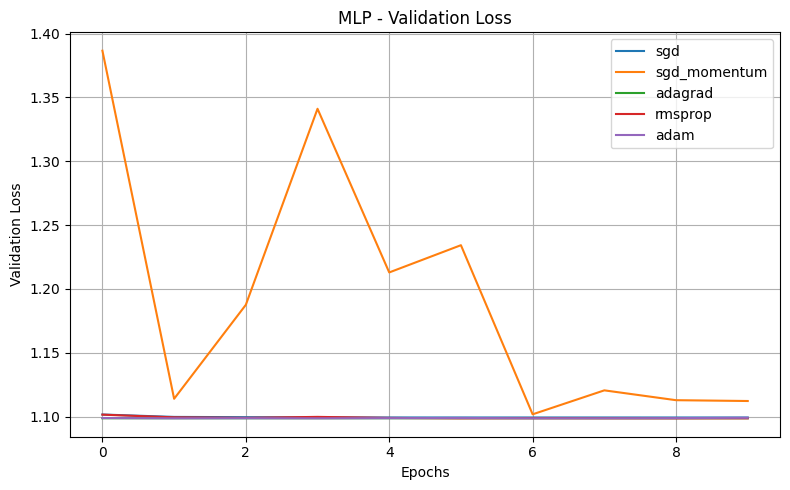

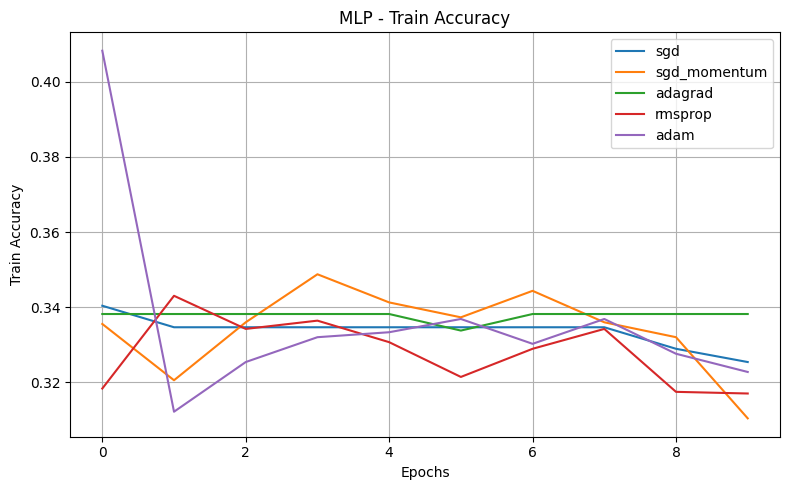

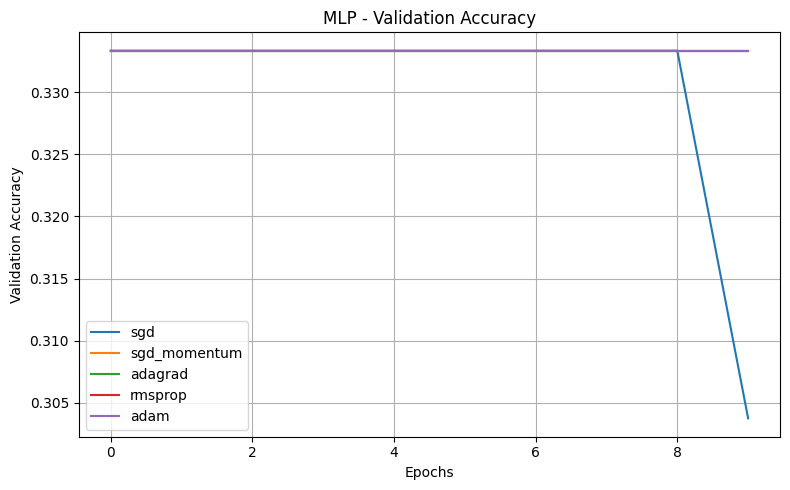

In [ ]:
import os
import json
import matplotlib.pyplot as plt

base_paths = {
    "MLP": "/content/drive/MyDrive/Rock_Paper_Scissors_Models/mlp",
    "CNN": "/content/drive/MyDrive/Rock_Paper_Scissors_Models/cnn"
}

optimizers = ['sgd', 'sgd_momentum', 'adagrad', 'rmsprop', 'adam']

metrics_map = {
    'loss': 'Train Loss',
    'val_loss': 'Validation Loss',
    'accuracy': 'Train Accuracy',
    'val_accuracy': 'Validation Accuracy'
}

def load_histories(base_path):
    histories = {}
    for opt in optimizers:
        path = os.path.join(base_path, opt, 'history.json')
        if os.path.exists(path):
            with open(path, 'r') as f:
                histories[opt] = json.load(f)
        else:
            print(f"⚠️ Missing file: {path}")
    return histories
# Function to plot all metrics
def plot_all_metrics(histories, model_type):
    for metric_key, title in metrics_map.items():
        plt.figure(figsize=(8, 5))
        for optimizer_name, hist in histories.items():
            if metric_key in hist:
                plt.plot(hist[metric_key], label=optimizer_name)
        plt.title(f"{model_type} - {title}")
        plt.xlabel("Epochs")
        plt.ylabel(title)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

mlp_histories = load_histories(base_paths["MLP"])
plot_all_metrics(mlp_histories, "MLP")


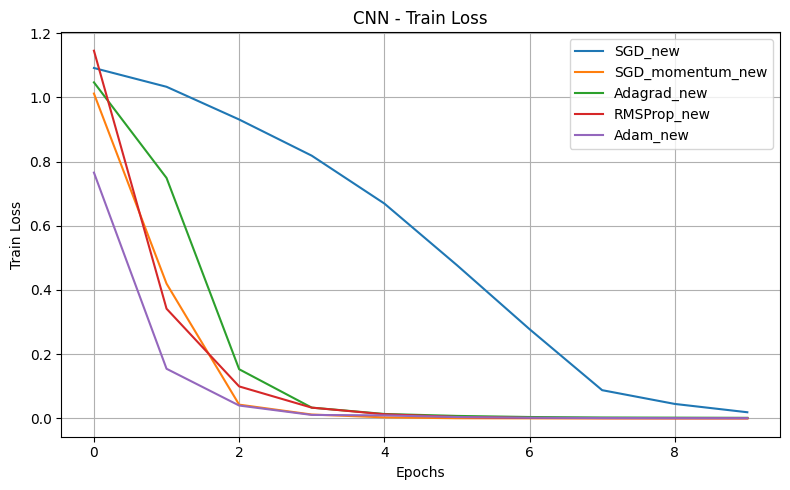

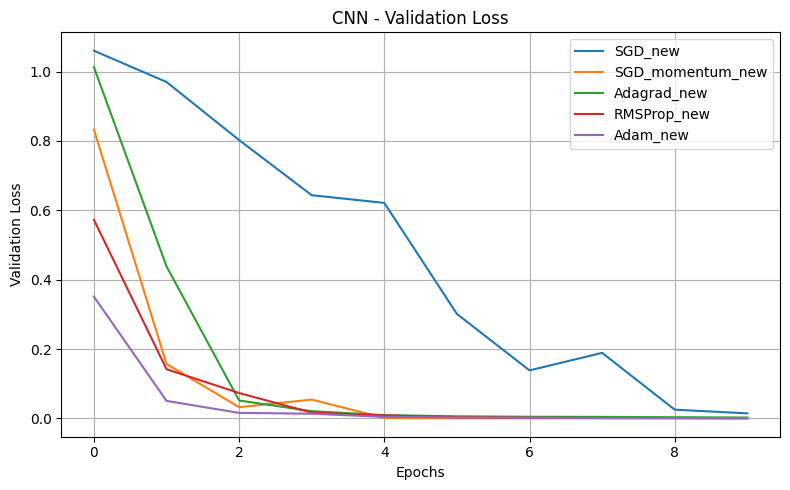

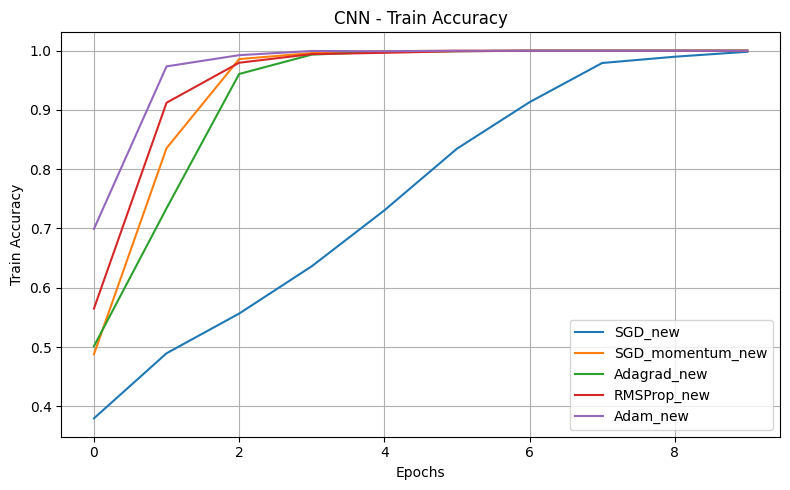

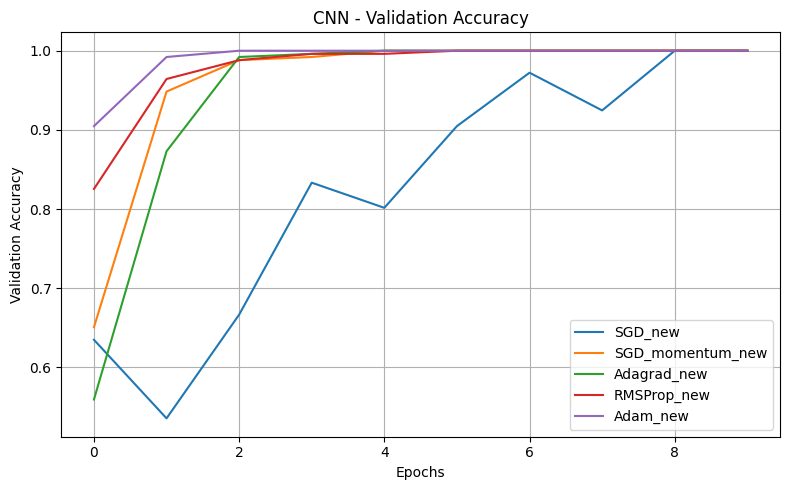

In [ ]:
import os
import json
import matplotlib.pyplot as plt

base_paths = {
    "MLP": "/content/drive/MyDrive/Rock_Paper_Scissors_Models/mlp",
    "CNN": "/content/drive/MyDrive/Rock_Paper_Scissors_Models/cnn"
}

optimizers = ['SGD_new', 'SGD_momentum_new', 'Adagrad_new', 'RMSProp_new', 'Adam_new']

metrics_map = {
    'loss': 'Train Loss',
    'val_loss': 'Validation Loss',
    'accuracy': 'Train Accuracy',
    'val_accuracy': 'Validation Accuracy'
}

def load_histories(base_path):
    histories = {}
    for opt in optimizers:
        path = os.path.join(base_path, opt, 'history.json')
        if os.path.exists(path):
            with open(path, 'r') as f:
                histories[opt] = json.load(f)
        else:
            print(f"⚠️ Missing file: {path}")
    return histories
# Function to plot all metrics
def plot_all_metrics(histories, model_type):
    for metric_key, title in metrics_map.items():
        plt.figure(figsize=(8, 5))
        for optimizer_name, hist in histories.items():
            if metric_key in hist:
                plt.plot(hist[metric_key], label=optimizer_name)
        plt.title(f"{model_type} - {title}")
        plt.xlabel("Epochs")
        plt.ylabel(title)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


cnn_histories = load_histories(base_paths["CNN"])
plot_all_metrics(cnn_histories, "CNN")

----------------------------------------------

**Evaluation Table**

In [ ]:
import os
import json
from tensorflow.keras.models import load_model

base_path = '/content/drive/MyDrive/Rock_Paper_Scissors_Models/mlp'
optimizers = ['sgd', 'sgd_momentum', 'adagrad', 'rmsprop', 'adam']

def get_final_metrics_from_history(history):
    return {
        'Train Loss': round(history['loss'][-1], 4),
        'Train Acc': round(history['accuracy'][-1], 4),
        'Val Loss': round(history['val_loss'][-1], 4),
        'Val Acc': round(history['val_accuracy'][-1], 4),
    }

def print_metrics_table(results_dict):
    print("+" + "-"*80 + "+")
    print("| {:<15} | {:<20} | {:<20} | {:<20} | {:<20} |".format(
        "Model", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"
    ))
    print("+" + "-"*80 + "+")
    for model_name, metrics in results_dict.items():
        print("| {:<15} | {:<20} | {:<20} | {:<20} | {:<20} |".format(
            model_name,
            metrics['Train Loss'],
            metrics['Train Acc'],
            metrics['Val Loss'],
            metrics['Val Acc']
        ))
    print("+" + "-"*80 + "+")


results = {}
for opt in optimizers:
    history_path = os.path.join(base_path, opt, "history.json")
    if os.path.exists(history_path):
        with open(history_path, "r") as f:
            history = json.load(f)
            results[opt.upper().replace("_", " ")] = get_final_metrics_from_history(history)
    else:
        print(f"History missing for {opt}")


print("MLP:")
print_metrics_table(results)

MLP:
+--------------------------------------------------------------------------------+
| Model           | Train Loss           | Train Accuracy       | Val Loss             | Val Accuracy         |
+--------------------------------------------------------------------------------+
| SGD             | 1.0987               | 0.3254               | 1.0993               | 0.3038               |
| SGD MOMENTUM    | 1.2035               | 0.3104               | 1.1122               | 0.3333               |
| ADAGRAD         | 1.0986               | 0.3382               | 1.0987               | 0.3333               |
| RMSPROP         | 1.0996               | 0.317                | 1.0986               | 0.3333               |
| ADAM            | 1.099                | 0.3228               | 1.0991               | 0.3333               |
+--------------------------------------------------------------------------------+


In [ ]:
cnn_base_path = '/content/drive/MyDrive/Rock_Paper_Scissors_Models/cnn'
optimizers = ['SGD_new', 'SGD_momentum_new', 'Adagrad_new', 'RMSProp_new', 'Adam_new']

def get_final_metrics_from_history(history):
    return {
        'Train Loss': round(history['loss'][-1], 4),
        'Train Acc': round(history['accuracy'][-1], 4),
        'Val Loss': round(history['val_loss'][-1], 4),
        'Val Acc': round(history['val_accuracy'][-1], 4),
    }

def print_metrics_table(results_dict):
    print("+" + "-"*80 + "+")
    print("| {:<15} | {:<20} | {:<20} | {:<20} | {:<20} |".format(
        "Model", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"
    ))
    print("+" + "-"*80 + "+")
    for model_name, metrics in results_dict.items():
        print("| {:<15} | {:<20} | {:<20} | {:<20} | {:<20} |".format(
            model_name,
            metrics['Train Loss'],
            metrics['Train Acc'],
            metrics['Val Loss'],
            metrics['Val Acc']
        ))
    print("+" + "-"*80 + "+")


cnn_results = {}
for opt in optimizers:
    history_path = os.path.join(cnn_base_path, opt, "history.json")
    if os.path.exists(history_path):
        with open(history_path, "r") as f:
            history = json.load(f)
            cnn_results[opt.upper().replace("_", " ")] = get_final_metrics_from_history(history)
    else:
        print(f"History missing for {opt}")


print("CNN:")
print_metrics_table(cnn_results)

CNN:
+--------------------------------------------------------------------------------+
| Model           | Train Loss           | Train Accuracy       | Val Loss             | Val Accuracy         |
+--------------------------------------------------------------------------------+
| SGD NEW         | 0.019                | 0.9982               | 0.0147               | 1.0                  |
| SGD MOMENTUM NEW | 0.0                  | 1.0                  | 0.0004               | 1.0                  |
| ADAGRAD NEW     | 0.0016               | 1.0                  | 0.0027               | 1.0                  |
| RMSPROP NEW     | 0.0002               | 1.0                  | 0.0004               | 1.0                  |
| ADAM NEW        | 0.0007               | 1.0                  | 0.001                | 1.0                  |
+--------------------------------------------------------------------------------+


**Analysis**

MLP models reached a val accuracy of 0.33 using all optimizers , why is that the case ??

due to the huge number of connections that were introuduced with the flattenning layer MLP doesnt generalize or learn any patterns instead it jsut guesse between 3  random classes rock , paper , scissors hence the 0.33 val acc



CNN is performing nearly perfcet if not perfect due to the fact that it learns spatial features high and low level.


CNN is performing better than MLP why is that the case ??

 CNN is showing improvment in accuracy and variation in val acc that means it is learning patterns and generalizing

**Conclusion**

both MLP and CNN models were trained using five different optimizers.
The MLP models consistently reached a validation accuracy of 0.33 across all optimizers, confirming that they are not suitable for image-based tasks due to their inability to learn spatial features.

On the other hand, the CNN models showed clear learning patterns and varied validation accuracy depending on the optimizer used — with optimizers like RMSProp and Adam showing faster convergence but longer training time .

This comparison illustrates that MLP is not suitable for image classification while CNN is the appropriate architecture for that

# Evaluation (Test Set)

This is the same helper function i am just editing it out to represtn testing values as i saved it differetly and its easier to edit the function than rerun the evaluation

In [ ]:
def print_metrics_table_test(results_dict):
    print("+" + "-"*80 + "+")
    print("| {:<15} | {:<20} | {:<20} | {:<20} | {:<20} |".format(
        "Model", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"
    ))
    print("+" + "-"*80 + "+")
    for model_name, metrics in results_dict.items():
        print("| {:<15} | {:<20} | {:<20} | {:<20} | {:<20} |".format(
            model_name,
            metrics['Train Loss'],
            metrics['Train Accuracy'],  # <-- fixed here
            metrics['Val Loss'],
            metrics['Val Accuracy']     # <-- and here
        ))
    print("+" + "-"*80 + "+")

Batching and preproccessing dataset , preprocessing the test set is not cheating on the dataset as i thought its what happens in real apps when we capture an image we prprocess it internally its not cheating on the dataset

In [ ]:
ds_test = ds_test.map(preprocess).batch(32)

In [ ]:
def evaluate_models_mlp(base_path, ds_test):
    model_type = "mlp"
    optimizers = ['sgd', 'sgd_momentum', 'adagrad', 'rmsprop', 'adam']
    results = {}

    for opt in optimizers:
        model_path = os.path.join(base_path, model_type, opt, "model.keras")
        history_path = os.path.join(base_path, model_type, opt, "history.json")

        model = tf.keras.models.load_model(model_path)
        with open(history_path, "r") as f:
            history = json.load(f)

        test_loss, test_accuracy = model.evaluate(ds_test, verbose=0)

        results[opt] = {
            "Train Loss": round(history["loss"][-1], 4),
            "Train Accuracy": round(history["accuracy"][-1], 4),
            "Val Loss": round(history["val_loss"][-1], 4),
            "Val Accuracy": round(history["val_accuracy"][-1], 4),
            "Test Loss": round(test_loss, 4),
            "Test Accuracy": round(test_accuracy, 4),
        }

    return results

In [ ]:
mlp_results = evaluate_models_mlp(base_path,ds_test)

In [ ]:
print_metrics_table_test(mlp_results)

+--------------------------------------------------------------------------------+
| Model           | Train Loss           | Train Accuracy       | Val Loss             | Val Accuracy         |
+--------------------------------------------------------------------------------+
| sgd             | 1.0987               | 0.3254               | 1.0993               | 0.3038               |
| sgd_momentum    | 1.2035               | 0.3104               | 1.1122               | 0.3333               |
| adagrad         | 1.0986               | 0.3382               | 1.0987               | 0.3333               |
| rmsprop         | 1.0996               | 0.317                | 1.0986               | 0.3333               |
| adam            | 1.099                | 0.3228               | 1.0991               | 0.3333               |
+--------------------------------------------------------------------------------+


In [ ]:

def evaluate_models_cnn(base_path, ds_test):
    model_type = "cnn"
    optimizers = ['SGD_new', 'SGD_momentum_new', 'Adagrad_new', 'RMSProp_new', 'Adam_new']
    results = {}

    for opt in optimizers:
        model_path = os.path.join(base_path, model_type, opt, "model.keras")
        history_path = os.path.join(base_path, model_type, opt, "history.json")

        model = tf.keras.models.load_model(model_path)
        with open(history_path, "r") as f:
            history = json.load(f)

        test_loss, test_accuracy = model.evaluate(ds_test, verbose=0)

        results[opt] = {
            "Train Loss": round(history["loss"][-1], 4),
            "Train Accuracy": round(history["accuracy"][-1], 4),
            "Val Loss": round(history["val_loss"][-1], 4),
            "Val Accuracy": round(history["val_accuracy"][-1], 4),
            "Test Loss": round(test_loss, 4),
            "Test Accuracy": round(test_accuracy, 4),
        }

    return results

In [ ]:
cnn_results = evaluate_models_cnn(base_path,ds_test)

In [ ]:
print_metrics_table_test(cnn_results)

+--------------------------------------------------------------------------------+
| Model           | Train Loss           | Train Accuracy       | Val Loss             | Val Accuracy         |
+--------------------------------------------------------------------------------+
| SGD_new         | 0.019                | 0.9982               | 0.0147               | 1.0                  |
| SGD_momentum_new | 0.0                  | 1.0                  | 0.0004               | 1.0                  |
| Adagrad_new     | 0.0016               | 1.0                  | 0.0027               | 1.0                  |
| RMSProp_new     | 0.0002               | 1.0                  | 0.0004               | 1.0                  |
| Adam_new        | 0.0007               | 1.0                  | 0.001                | 1.0                  |
+--------------------------------------------------------------------------------+


In [ ]:
def plot_mlp_metrics(mlp_results):
    metrics = ["Train Loss", "Val Loss", "Train Accuracy", "Val Accuracy"]
    for metric in metrics:
        optimizers = list(mlp_results.keys())
        values = [mlp_results[opt][metric] for opt in optimizers]

        plt.figure(figsize=(8, 5))
        plt.plot(optimizers, values, marker='o', linestyle='-')
        plt.title(f"MLP - {metric}")
        plt.xlabel("Optimizer")
        plt.ylabel(metric)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


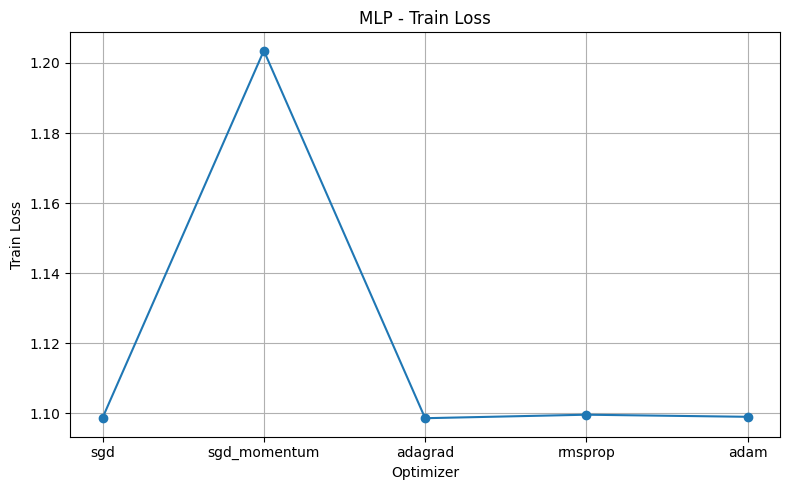

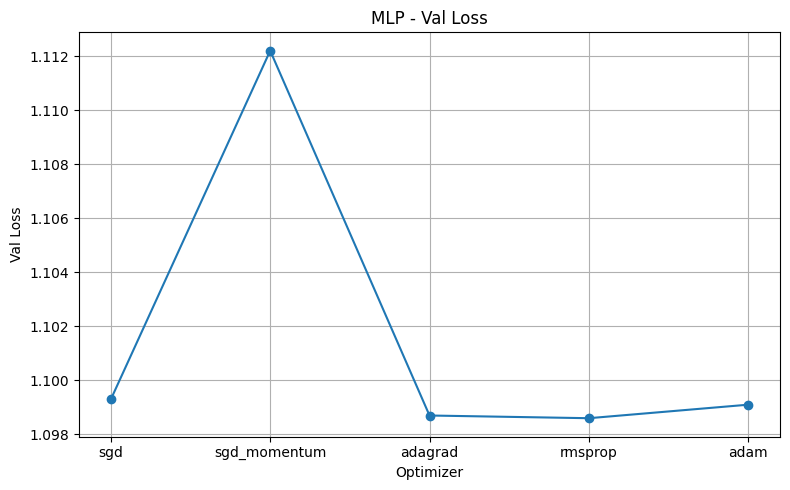

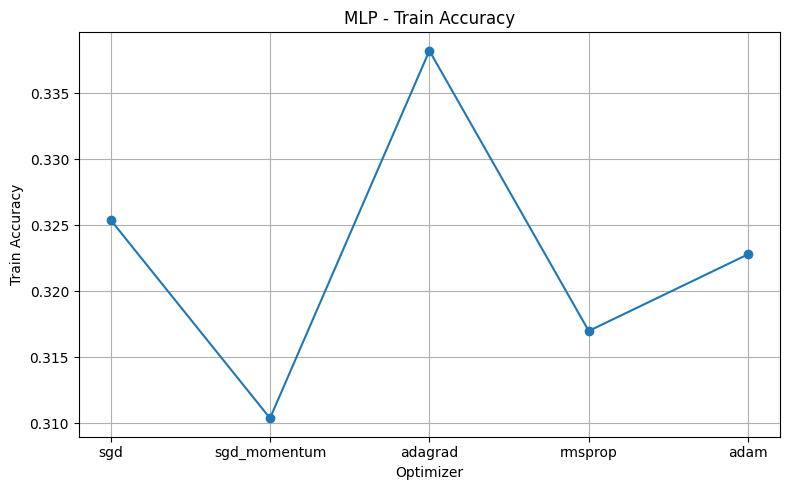

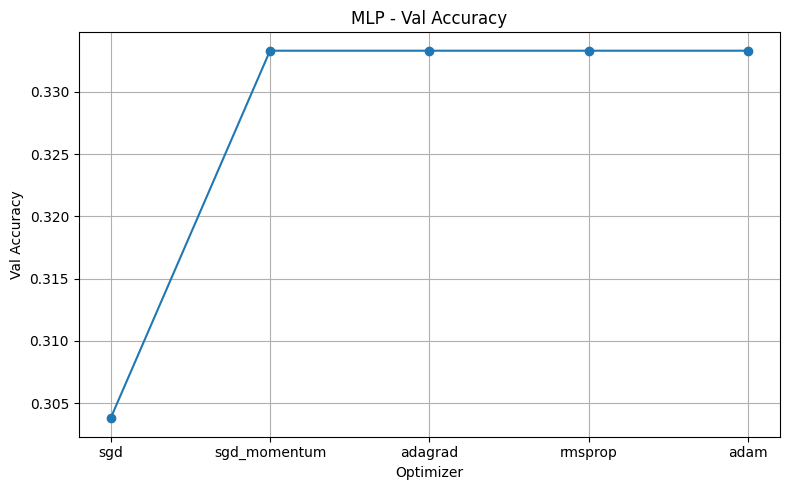

In [ ]:
plot_mlp_metrics(mlp_results)

In [ ]:
def plot_cnn_metrics(cnn_results):
    metrics = ["Train Loss", "Val Loss", "Train Accuracy", "Val Accuracy"]
    for metric in metrics:
        optimizers = list(cnn_results.keys())
        values = [cnn_results[opt][metric] for opt in optimizers]

        plt.figure(figsize=(8, 5))
        plt.plot(optimizers, values, marker='o', linestyle='-')
        plt.title(f"CNN - {metric}")
        plt.xlabel("Optimizer")
        plt.ylabel(metric)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

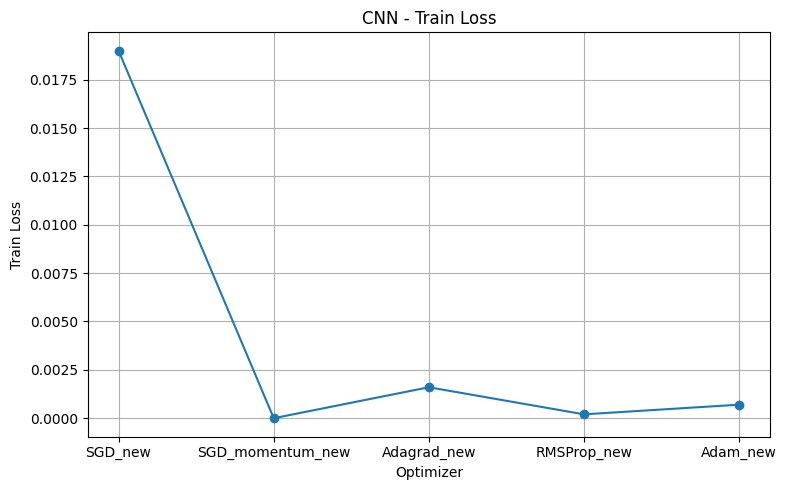

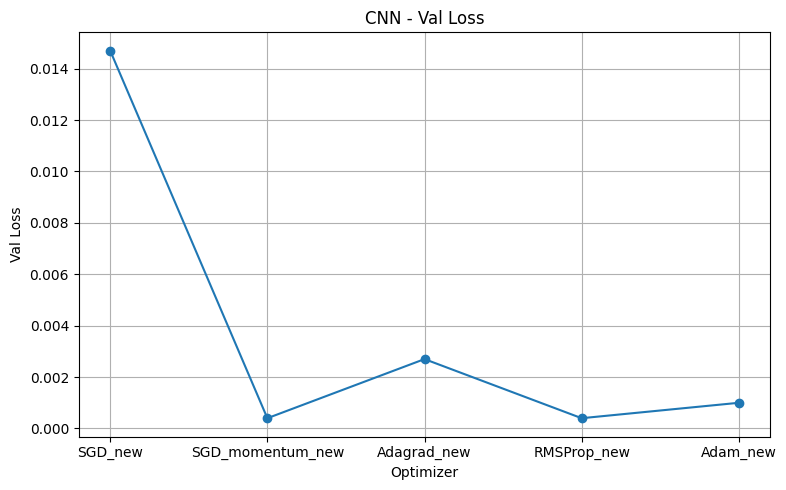

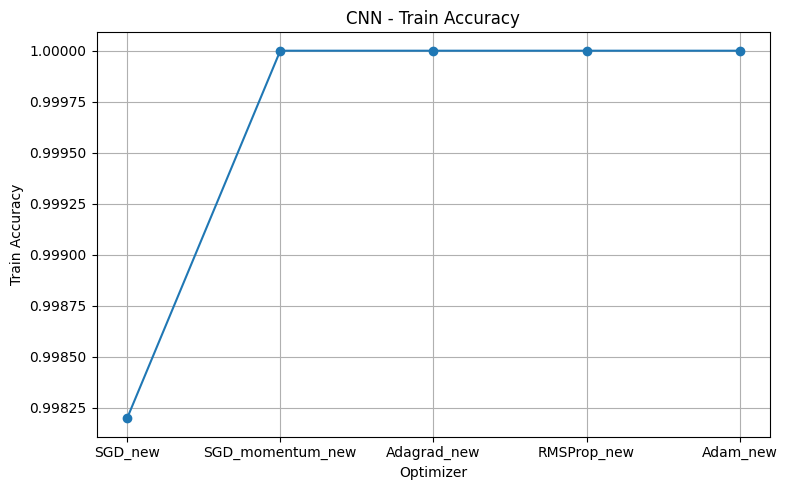

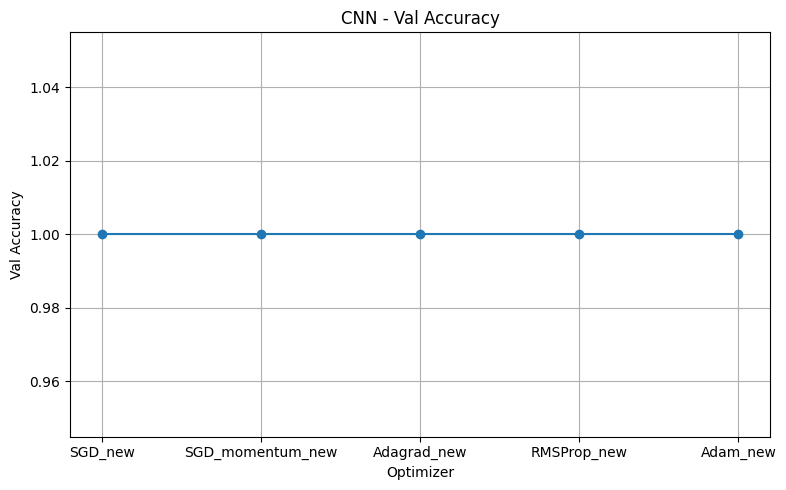

In [ ]:
plot_cnn_metrics(cnn_results)

**Conclusion**

both MLP and CNN models were trained using five different optimizers.
The MLP models consistently reached a validation accuracy of 0.33 across all optimizers, confirming that they are not suitable for image-based tasks due to their inability to learn spatial features.

On the other hand, the CNN models showed clear learning patterns and varied validation accuracy depending on the optimizer used — with optimizers like RMSProp and Adam showing faster convergence but longer training time .

This comparison illustrates that MLP is not suitable for image classification while CNN is the appropriate architecture for that